In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF


import warnings
warnings.filterwarnings('ignore')


In [2]:
wholesale=pd.read_csv(r"C:\Users\ASUS\Desktop\github\customerSegmentation\Wholesale customers data.csv")

In [3]:
wholesale.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [25]:
wholesale.drop(["Channel","Region"],inplace=True,axis=1)

In [26]:
wholesale.agg(['mean','std']).round(0)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
mean,12000.0,5796.0,7951.0,3072.0,2881.0,1525.0
std,12647.0,7380.0,9503.0,4855.0,4768.0,2820.0


## Pairwise plot review

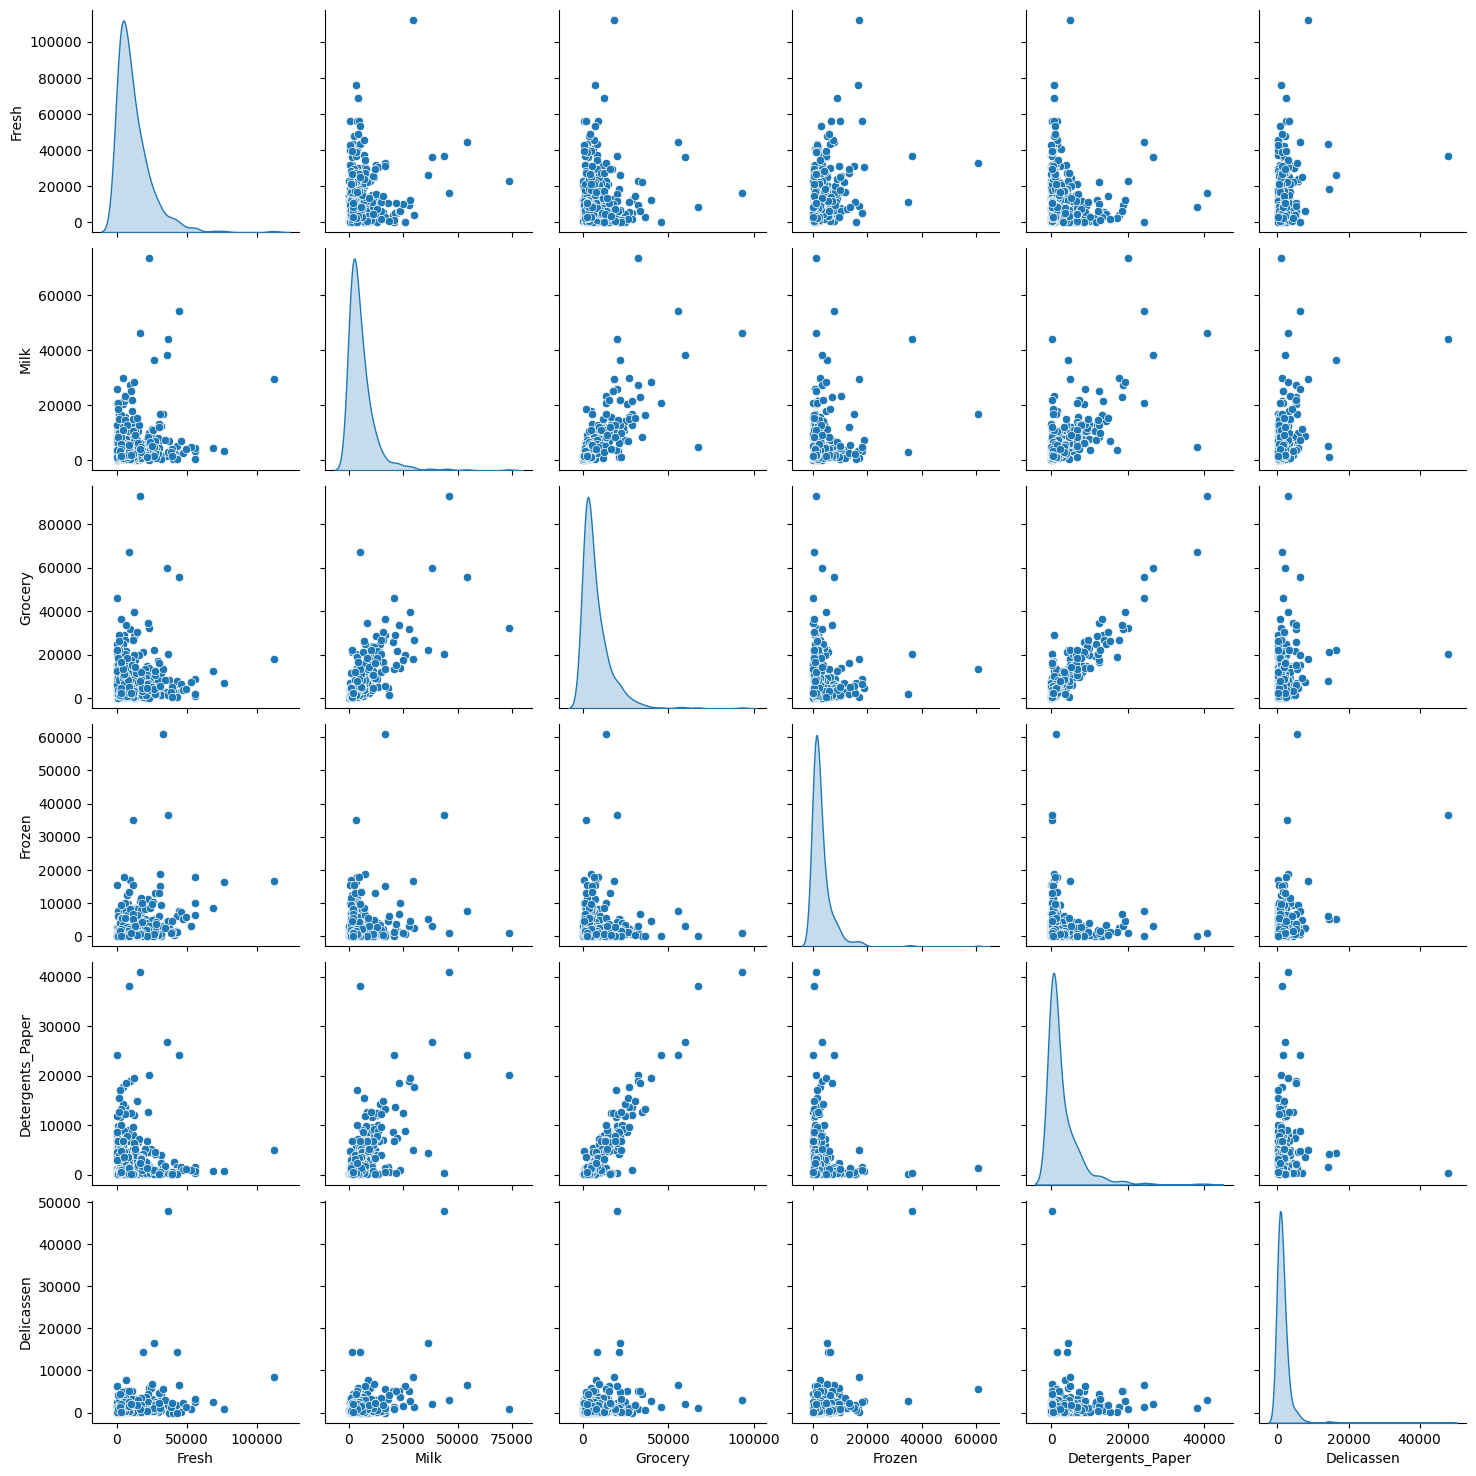

In [27]:
sns.pairplot(wholesale,diag_kind='kde')
plt.show()

#### We see that the estimated distributions on the diagonal are highly skewed which means they are not normally distributed.

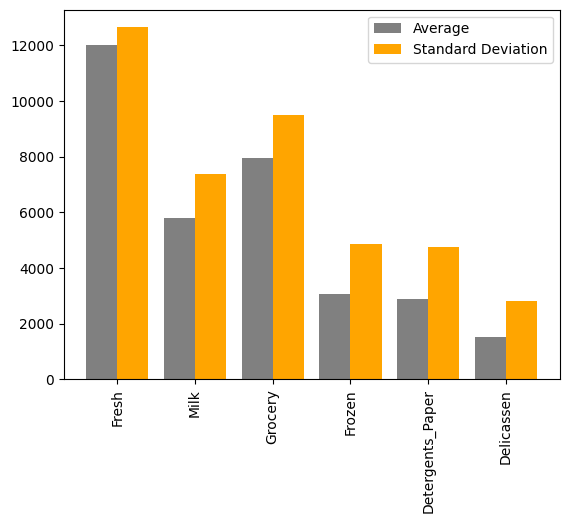

In [28]:
# Create column names list and same length integer list
x_names = wholesale.columns
x_ix = np.arange(wholesale.shape[1])
averages=wholesale.mean()
std_devs=wholesale.std()

# Plot the averages data in gray and standard deviations in orange 
plt.bar(x=x_ix-0.2, height=averages, color='grey', label='Average', width=0.4)  # offset them by 0.2 so they don't overlap
plt.bar(x=x_ix+0.2, height=std_devs, color='orange', label='Standard Deviation', width=0.4)

# Add x-axis labels and rotate
plt.xticks(ticks=x_ix, labels=x_names, rotation=90)

# Add the legend and display the chart
plt.legend()
plt.show()

#### It's clear we have large differences in both average and standard deviation values across variables.

## Data preparation for segmentation

#### We will first start with building segmentation with K-means clustering. This method discovers segments well, only when the input variables are somewhat normally distributed, meaning there's no skewness which we observed in the pairwise plot. Also, K-means expects the data to be standardized with average value 0 and standard deviation of 1. 

### Unskewing data with log-transformation

In [29]:
wholesale_log=np.log(wholesale)

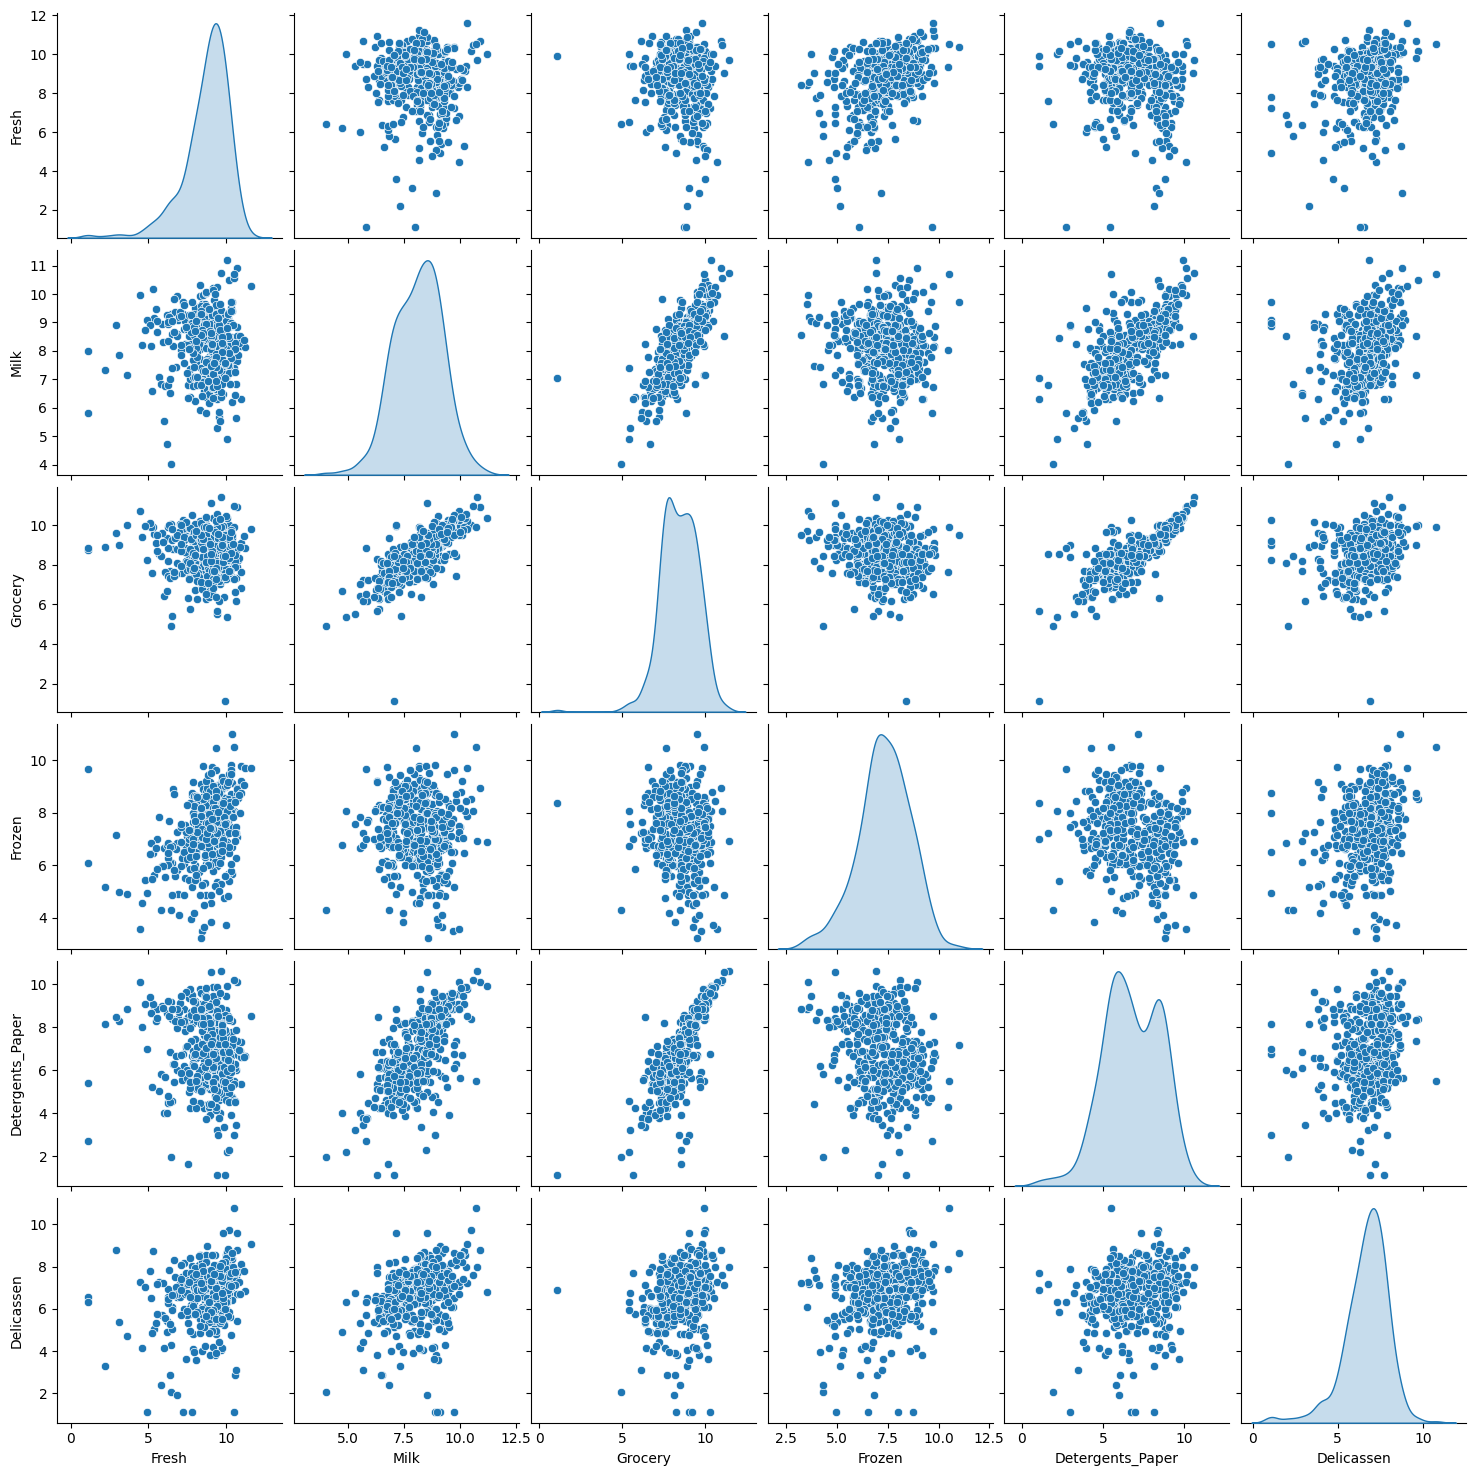

In [30]:
sns.pairplot(wholesale_log,diag_kind='kde')
plt.show()

#### We can see that the variables are less skewed and look more bell-shaped, although the Fresh variable is still slightly skewed to the left.

### Unskewing data with Box-Cox transformation

In [31]:
def boxcox_df(x):
    x_boxcox,_=stats.boxcox(x)
    return x_boxcox

wholesale_boxcox=wholesale.apply(boxcox_df,axis=0)

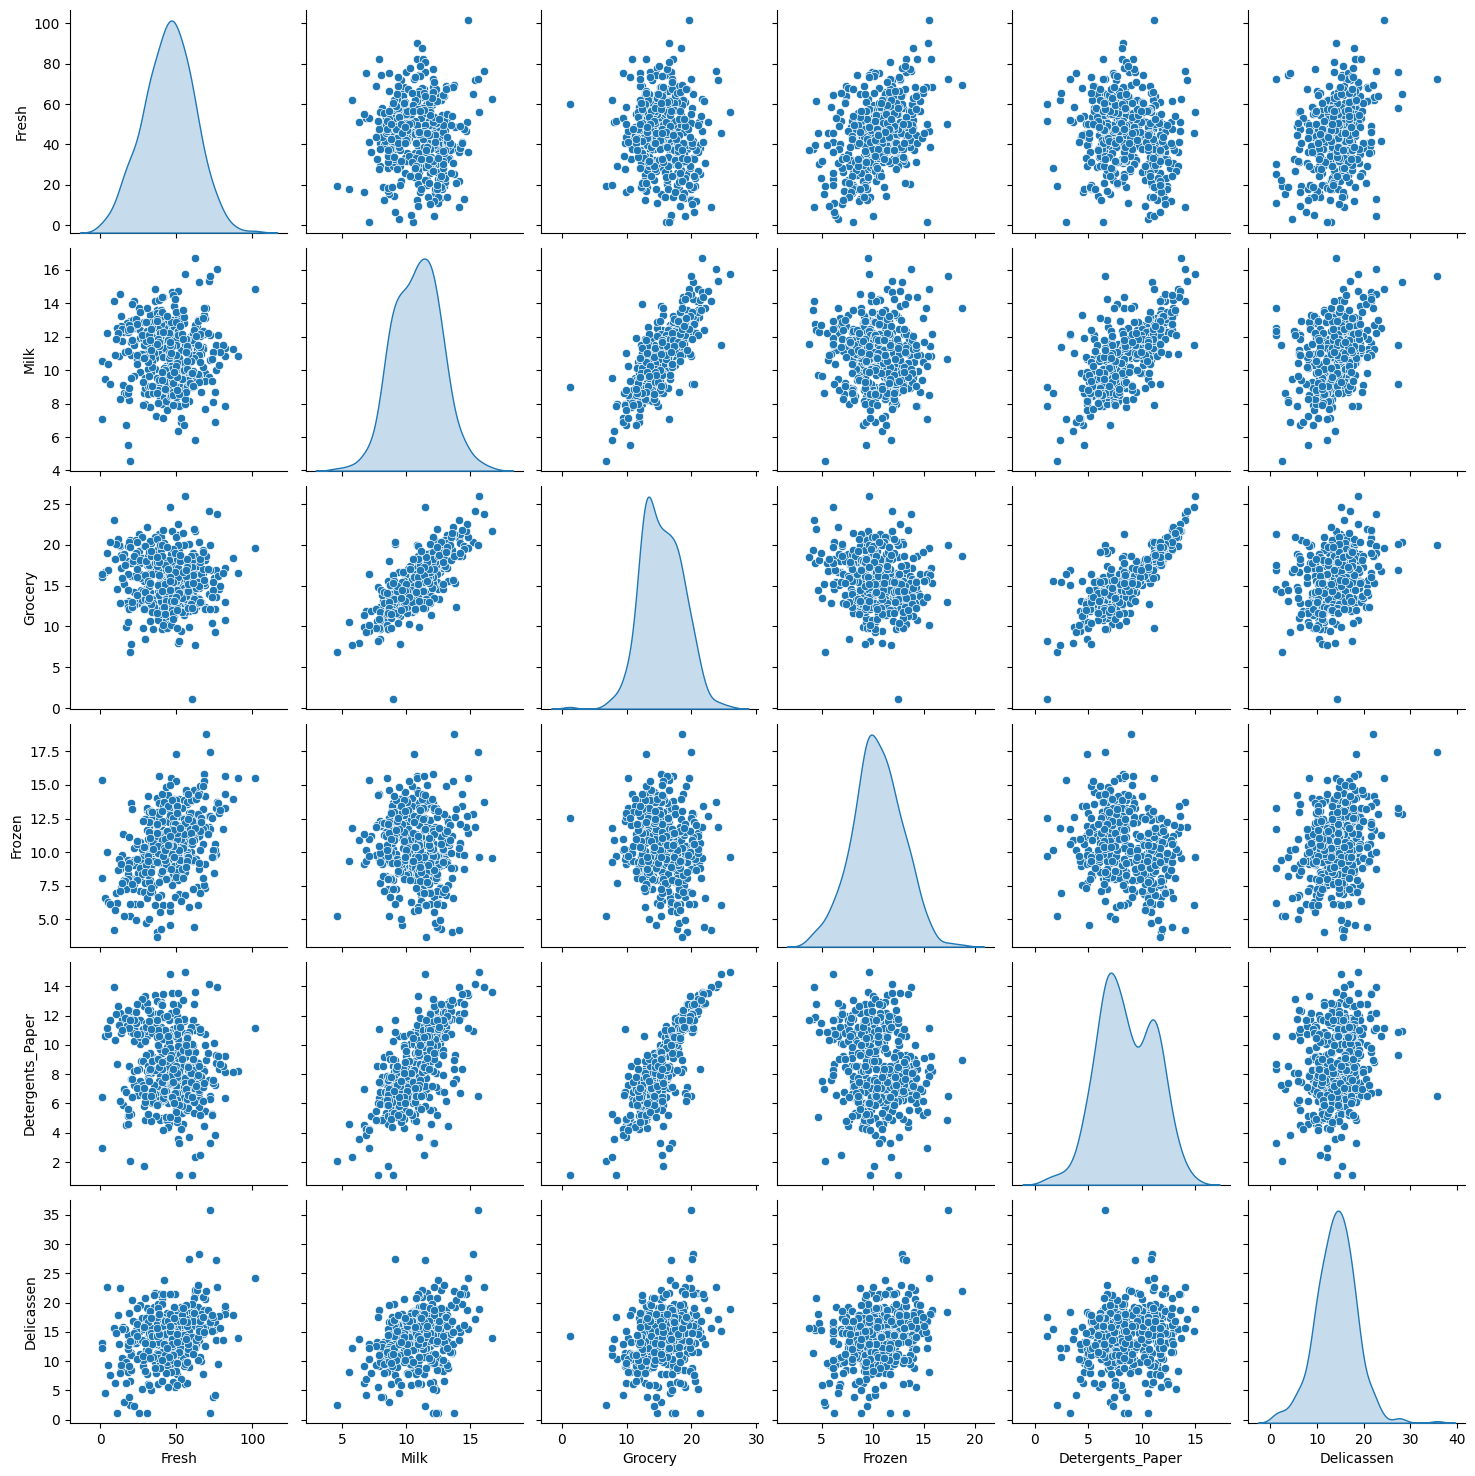

In [32]:
sns.pairplot(wholesale_boxcox,diag_kind='kde')
plt.show()

## Scale the data
#### Scaled data is expected by K-means method. Otherwise it will not find well separated clusters. Scaling works by first subtracting the column average from each individual entry. This step ensures the column average is adjusted to zero. Then we divide the result by each column's standard deviation. This step makes the column's standard deviation equal to 1.

In [33]:
scaler=StandardScaler()
# Fit the initialized `scaler` instance on the Box-Cox transformed dataset
scaler.fit(wholesale_boxcox)

# Transform and store the scaled dataset as `wholesale_scaled`
wholesale_scaled = scaler.transform(wholesale_boxcox)

# Create a `pandas` DataFrame from the scaled dataset
wholesale_scaled_df = pd.DataFrame(data=wholesale_scaled,
                                       index=wholesale_boxcox.index,
                                       columns=wholesale_boxcox.columns)

# Print the mean and standard deviation for all columns
print(wholesale_scaled_df.agg(['mean','std']).round())

      Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
mean   -0.0   0.0     -0.0    -0.0              -0.0        -0.0
std     1.0   1.0      1.0     1.0               1.0         1.0


## Build customer and product segmentation
### KMean

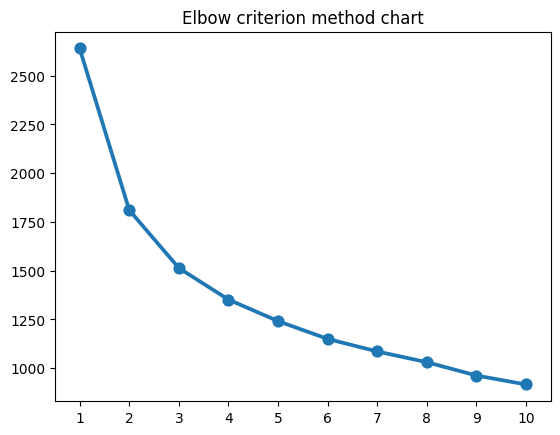

In [40]:
# Create empty sse dictionary
sse = {}

# Fit KMeans algorithm on k values between 1 and 11
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=333)
    kmeans.fit(wholesale_scaled_df)
    sse[k] = kmeans.inertia_

# Add the title to the plot
plt.title('Elbow criterion method chart')

# Create and display a scatter plot
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [44]:
kmeans=KMeans(n_clusters=4, random_state=123)

# Fit the model on the pre-processed dataset
kmeans.fit(wholesale_scaled_df)

# Assign the generated labels to a new column
wholesale_kmeans4 = wholesale.assign(segment = kmeans.labels_)

In [45]:
wholesale_kmeans4

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,segment
0,12669,9656,7561,214,2674,1338,0
1,7057,9810,9568,1762,3293,1776,0
2,6353,8808,7684,2405,3516,7844,0
3,13265,1196,4221,6404,507,1788,3
4,22615,5410,7198,3915,1777,5185,3
...,...,...,...,...,...,...,...
435,29703,12051,16027,13135,182,2204,3
436,39228,1431,764,4510,93,2346,3
437,14531,15488,30243,437,14841,1867,0
438,10290,1981,2232,1038,168,2125,1


## NMF

In [47]:
# Initialize NMF instance with 4 components
nmf = NMF(4)

# Fit the model on the wholesale sales data  the raw - not pre-processed 
nmf.fit(wholesale)  

# Extract the components 
components = pd.DataFrame(data=nmf.components_, columns=wholesale.columns) #The components dataset is a segment by product matrix with segment weights.

#### The components dataset is a segment by product matrix with segment weights. We can get cluster assignment by extracting the cluster weights for each of the customer. We can do this by calling the transform method on the fitted nmf model, and assigning the column names (or cluster labels) from the components object index. Finally, we assign the customer index from the original wholesale dataset, and then create a new column in the original dataset by calculating which cluster weight is the largest for each customer, and choosing that label by calling idxmax function.

In [55]:
segment_weights=pd.DataFrame(nmf.transform(wholesale),columns=components.index)
segment_weights.index=wholesale.index
wholesale_nmf= wholesale.assign(segment=segment_weights.idxmax(axis=1)) #which cluster weight is the largest for each customer, and choosing that label by calling idxmax function.

## Visualize and interpret segmentation solution
#### Once the segments are built, the standard way to explore them is to calculate average, median or other percentile values for each variable, grouped by the segment label. Another approach is to calculate relative importance for each variable by segment


#### KMeans

In [48]:
kmeans4_averages= wholesale_kmeans4.groupby(['segment']).mean().round(0)
kmeans4_averages

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
segment,,,,,,
0,10229.0,12752.0,17996.0,1912.0,7767.0,2338.0
1,9923.0,1832.0,2368.0,2431.0,410.0,651.0
2,3739.0,6346.0,10622.0,689.0,4398.0,575.0
3,24453.0,5026.0,5028.0,7429.0,843.0,3009.0


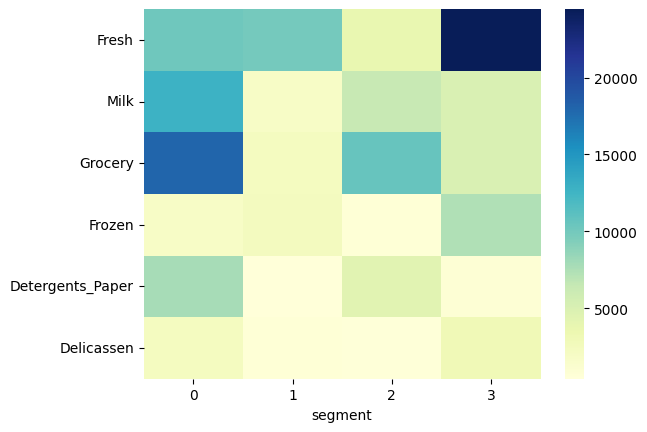

In [50]:
sns.heatmap(kmeans4_averages.T,cmap="YlGnBu") #we call the .T method to transpose it so it's more interpretable - it's a matter of personal taste 
plt.show()

### NMF

In [56]:
nmf_averages= wholesale_nmf.groupby(['segment']).mean().round(0)
nmf_averages

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
segment,,,,,,
0,5108.0,8883.0,12139.0,2446.0,5036.0,1748.0
1,8905.0,1597.0,2447.0,16901.0,244.0,1029.0
2,11850.0,2803.0,11769.0,1866.0,3660.0,2137.0
3,18908.0,2992.0,3735.0,3430.0,769.0,1284.0


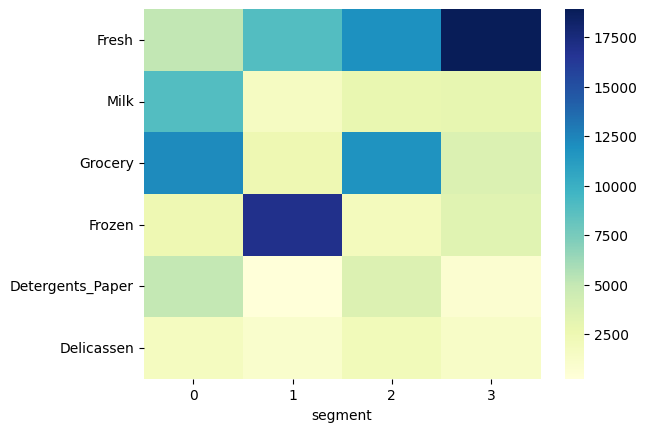

In [57]:
sns.heatmap(nmf_averages.T,cmap="YlGnBu") #we call the .T method to transpose it so it's more interpretable - it's a matter of personal taste 
plt.show()